+ Top 50 matplotlib  
https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

+ Top 21 Samsung Competitors – Competitor analysis of Samsung  
https://www.marketing91.com/samsung-competitors/  




# INDEX - code<a name="INDEX"></a>
---
+ ## [초기설정(필수)](#초기설정)
+ ## [심볼리스트 생성](#init)
+ ## [데이터 다운로드](#down)
+ ## [OLS](#ols)
+ ## [Joint Plot](#joint)
+ ## [데이터확인](#확인)
+ ## [co-kurtosis](#cokur)
+ ## [correlation](#corr)

# INDEX - presentation <a name="idx-pr"></a>
---
+ ## [연구 주제 및 방향](#topic)
+ ## [지표 설명](#indexes)
+ ## [삼성](#samsung)
+ ## [SK 하이닉스](#sk)
+ ## [네이버](#naver)
+ ## [결론](#concl)
+ ## [추후 계획](#plan)

# Note
---
+ read_csv 에서 오류가 난다면 Analyze.py에

```python
engine = 'python'
```
를 추가해 줘보자.

```python
pd.read_csv('data/'+target_1 + '.csv',index_col='Date',engine='python')
```

+ csv 파일이 제대로 되어있는지 확인하여보자  
        메모장으로 열었을 시에 제대로 ',' 로 구분되어야한다.  
        엑셀 파일을 받아서 csv로 변환이 잘 안되는 경우가 있다.

+ 출력이 스크롤 안에 안 들어가게 하기  
        Cell -> All output (또는 Current outputs) -> toggle scrolling  
        또는 cell 선택후 'o'

### [초기 설정](#INDEX)<a name="초기설정"></a>
+ 한글 출력을 위한 폰트 설정, 각 PC마다 환경이 다름 ([matlplot 한글폰트](matlplot%20한글폰트.ipynb).ipynb 참고)
+ 사용할 지표들 등록

In [1]:
import SymbolList as sl
import Analysis as an
import Visualization as vi
import numpy as np
import pandas as pd
import datetime as dt 
from statsmodels.formula.api import ols 
import seaborn as sns;  sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl


# matplot 설정
mpl.rcParams['axes.unicode_minus'] = False
# -*- coding: utf-8 -*-
plt.rc('font', family="LG PC")
# 리스트 설정
ten_kor = ['Samsung_Electronics','SK_hynix','LG_Electronics',
    '삼성SDI','엔씨소프트','카카오','삼성전기',
    'LG디스플레이','삼성SDS','네이버']
ten_US = [  'Apple','Microsoft','IBM','Oracle',
            'Amazon','Tesla','Alphabet','Facebook',
            'Cisco','타이완 반도체','Intel','오라클','SAP']
index_kor = '와이즈'
#index_US = 'IXT'
index_US = 'XLK'
#stan_US = ['IXT','VIX','BitCoin','MSCI','ten_Year_Treasury']
stan_US = ['XLK','VIX','BitCoin','MSCI','ten_Year_Treasury']

# IT 기업들 
#stan_US = ['XLK','ten_Year_Treasury','Apple','NVIDIA','AMD','퀄컴']

stan_1 = ['KOSPI','SK_hynix','XLK','VIX','BitCoin','MSCI','ten_Year_Treasury']

## [연구 주제 및 방향](#idx-pr)<a name="topic"></a>

국내 IT 상장 기업의 주가는 기업의 재무적 성과, 이벤트 외에도 국외 시장 변수의 영향을 받는 경우가 많다. 이 연구는 국내 IT 산업에 영향을 미치는 국외 지수는 어떤 것이 있고, 또 얼마나 설명력이 있는지 확인하는 것을 그 목표로 두었다.

IT 기업 중 시가 총액이 가장 큰 삼성전자와 IT 소프트웨어 기업 중 시가 총액이 가장 큰 네이버를 분석 대상으로 선정했다. 설명 변수로는 IXT지수, VIX지수, 비트코인 가격, 미국 10년채 금리, MSCI 신흥국 지수를 선택했다. 이후 1변수부터 5변수까지 넣고 각각에 대해 OLS를 돌려서 총 82가지의 경우의 수로 나누어 상관관계를 살펴보는 방식으로 연구를 진행했다. 각 변수마다 2016년 1월 1일부터 2018년 12월 31일까지 3개년에 걸친 일별 자료를 활용하였다.


## [지표 설명](#idx-pr)<a name="indexes"></a>

+ [와이즈](http://www.wiseindex.com/Index/Index#/WI610.0) - 와이즈 IT하드웨어 지수
+ [IXT](https://finance.yahoo.com/quote/%5EIXT?p=^IXT&.tsrc=fin-srch) : TECHNOLOGY SELECT SECTOR INDEX  - 현재 미사용, 온전한 3년치를 얻을 방법을 못 찾음
+ [XLK](https://finance.yahoo.com/quote/XLK?p=XLK&.tsrc=fin-srch): Technology Select Sector SPDR Fund 
+ [VIX](https://finance.yahoo.com/quote/ZM?p=ZM&.tsrc=fin-srch) : VelocityShares Daily 2x VIX Short-Term ETN(a.k.a 공포지수), S&P500지수 옵션 가격의 향후 30일 동안의 변동성에 대한 시장의 기대
+ [MSCI](https://finance.yahoo.com/quote/EEM?p=EEM&.tsrc=fin-srch) : iShares MSCI Emerging Markets ETF
+ [ten_Year_Treasury](https://finance.yahoo.com/quote/IEF?p=IEF&.tsrc=fin-srch) : iShares 7-10 Year Treasury Bond ETF

  IXT 지수는 S&P 500에 포함된 기업 중 IT 기업의 시가 총액 지수로 국내 IT 산업 주가가 미국 IT 산업 지수의 영향을 받는지 확인하기 위해서 설명 변수에 편입했다. 해당 지수를 직접 구할 수 없어 이를 대체할 자료로 Technology Select Sector SPDR Fund(XLK)를 이용했다. 이는 S&P 지수 펀드 중 하나로 시가 총액 비중으로 펀드를 담고 있어 비교적 정확한 대체 자료로 사용할 수 있다고 판단했다.
    
	VIX 지수는 S&P 500 지수 옵션 가격의 향후 30일 동안의 변동성에 대한 시장의 기대를 수치화한 자료로, 앞으로 미국 주식 시장에 대한 변동성이 국내 IT 산업에 영향을 미칠 수 있는지를 확인하기 위해 편입했다. 세계 주식 시장의 변동성이 커지고 위험이 높아질수록 신흥국의 자금이 빠져나가는 경우가 종종 있기 때문에 이를 검증하기 위해서 설명 변수에 포함시켰다.
    
	비트코인 가격은 IT 하드웨어 산업의 수요와 관련이 있다고 판단하여 포함시켰다. 비트코인의 가격이 증가하고 시장의 관심이 집중됨에 따라 비트코인을 채굴하기 위해 고사양의 반도체 수요가 높아졌다. 삼성전자는 메모리를 팔고 있기 때문에 직접적으로 큰 연관은 없었으나 세계 반도체 시장의 수요 증가가 삼성전자의 주가 상승과 유의미한 상관관계를 갖고 있는지 검증하고자 했다.
    
	미국 10년채 금리는 전체적인 시장의 경기 상황을 파악하기 위해서 포함시켰다. 미국 중장기채 금리는 시장의 다양한 거시 변수와 그에 대한 기대를 반영하고 있기 때문에 경기 파악을 위하여 가장 최적의 변수라고 생각했다. 다만, 미국 연방준비제도가 발표하는 금리가 아니라, 10년채 유통시장의 가격을 이용했다. 이를 위해 iShares 7-10 Year Treasury Bond ETF 자료를 이용했다. 국채 가격은 금리와 역의 관계를 갖고 있기 때문에 이를 참고하여 수치를 해석하였다.
    
	MSCI 신흥국 지수는 외국 자금의 프로그램 매매 영향을 확인하기 위해 설명 변수에 포함했다. 해당 지수에 새로운 신흥국이 포함될 경우 국내 비중이 줄어들면서 프로그램 매매에 의해 국내 주식 시장의 자금이 빠져나가기 때문에 이를 확인하고자 했다. 또, 세계 경제의 불확실성이 커질 경우 신흥국의 자금은 유출되고 미국으로 몰리는 경향이 있는데 이를 잘 표현하는 지수가 MSCI 신흥국 지수라고 생각하여 이를 확인할 수 있는 변수로 판단하였다.


# [OLS ](#INDEX)<a name="ols"></a>
```python
def ols_comb(             
           dep,inds,
           comb_num=1,
           show_summary = False,
           do_shift = True,
           show_plot = True,  
           show_line = False,
           weekly=True,
           start='2016-01-04',
           end='2018-12-28',
           engine='c'
            )
    ```

## [삼성전자](#idx-pr)<a name="samsung"></a>

삼성전자 전체적인 내용

삼성전자와 각 변수들을 1개씩 넣어서 OLS를 추정한 결과를 보면, 3년과 9년 결과 모두 금리와 VIX는 음의 상관관계를, XLK와 MSCI는 양의 상관관계가 나타납니다. 비트코인은 3년에서는 약한 상관관계를 보입니다. 

특히 MSCI의 R스퀘어가 0.32로 매우 높게 나타났습니다. 이는 삼성전자가 우리나라 시가총액이 가장 큰 기업이다 보니, MSCI에서도 차지하는 비중이 상당히 높아서 연관성이 클 수 밖에 없기 때문입니다.

전체적으로 보면, XLK와 MSCI가 가장 큰 영향을 준다는 것을 볼 수 있습니다. 특히 MSCI가 앞에서 말한 것과 같이 제일 큰 영향을 주고 있습니다.

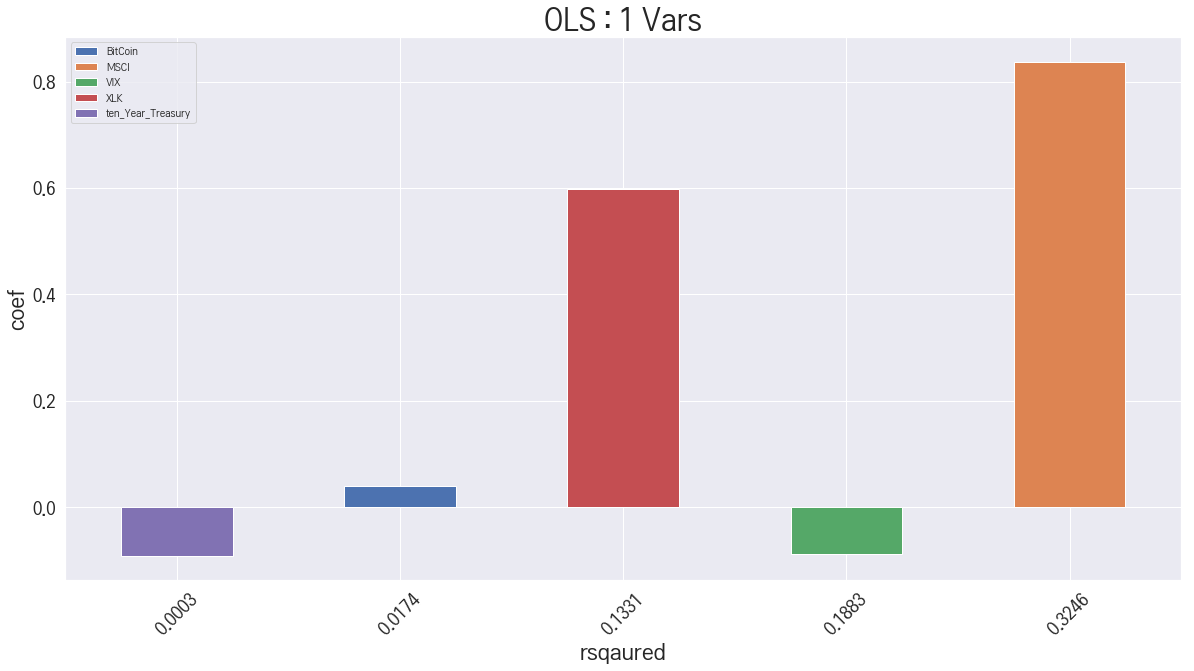

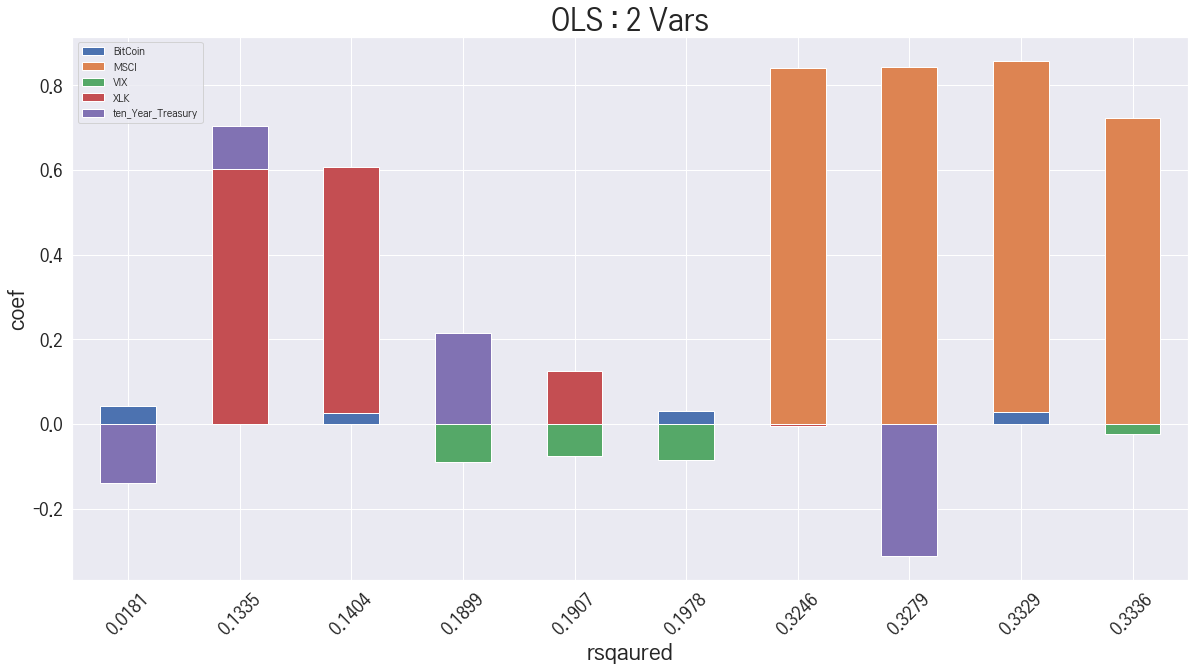

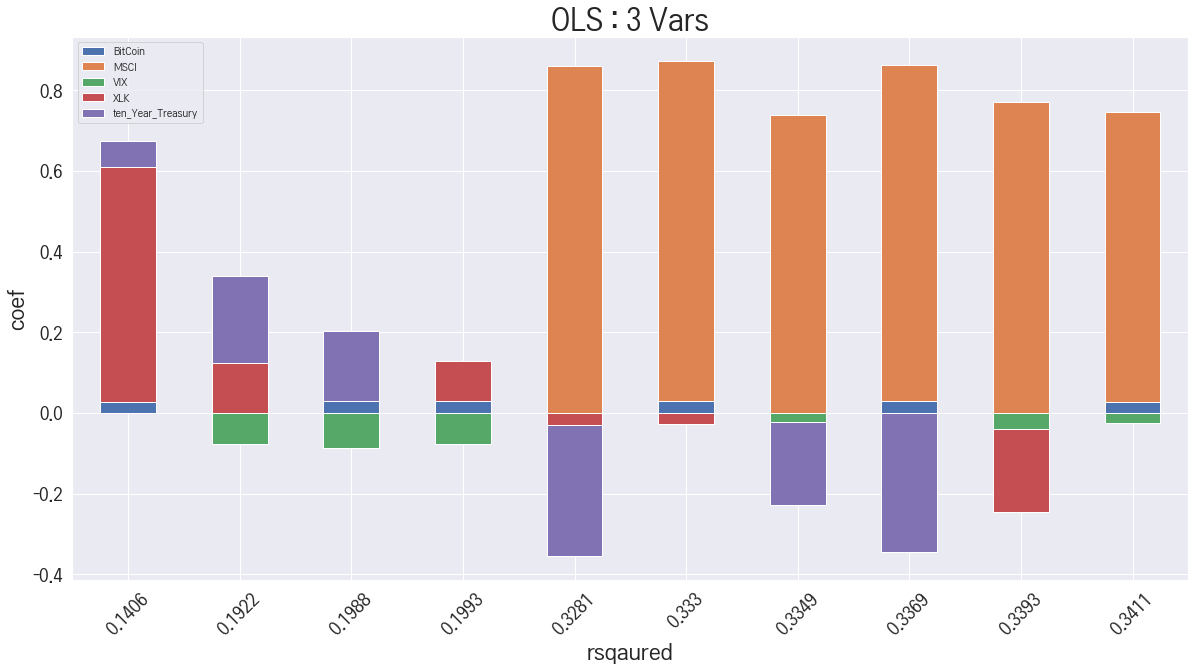

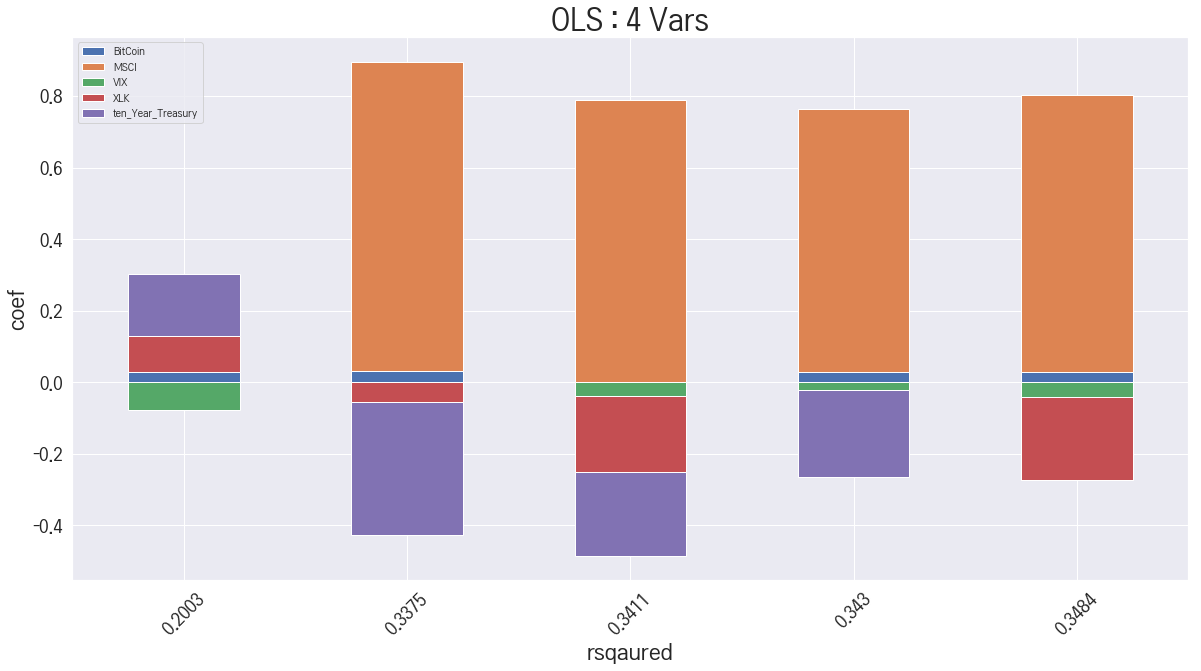

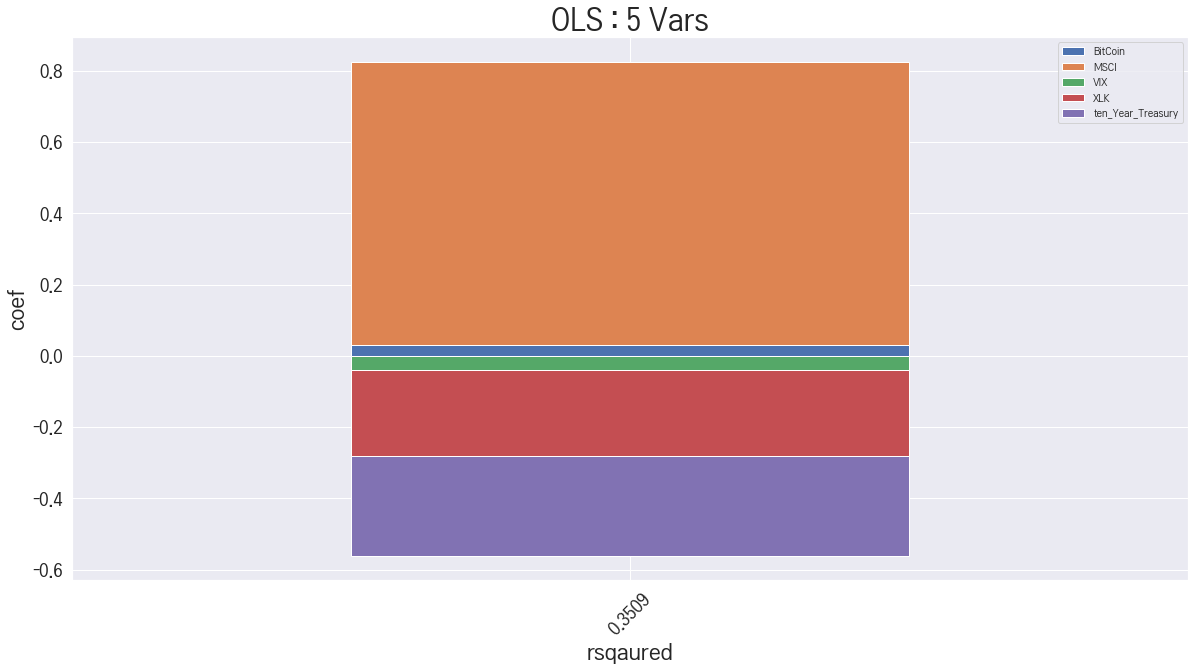

In [2]:
an.ols_comb(comb_num=1,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04', engine='c')
an.ols_comb(comb_num=2,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='c')
an.ols_comb(comb_num=3,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='c')
an.ols_comb(comb_num=4,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='c')
an.ols_comb(comb_num=5,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='c')

특이점


XLK는 3년에서 변수 4개 이상을 넣었을 때, 음의 관계 -> 9년으로 기간을 확대하면 양의관계

그 이유는 최근 3년간 미국의 IT 기업들만 호황이었기 때문으로 생각하였습니다. 최근 3년간 미국 IT 초거대기업들의 호황으로 인해 전체 주가지수는 상승하였습니다. 그렇지만 이들을 제외한 지수는 거의 성장하지 않을 것으로 봐서 실제 전세계 시장은 호황이 아니었습니다. 그래서 2010년 이후로 회귀분석을 하는 경우에는 양의 상관관계가 항상 나오지만, 최근 3년으로 회귀분석을 실시할 경우 음의 상관관계가 간혹 확인됩니다.


### 삼성전자 9개년

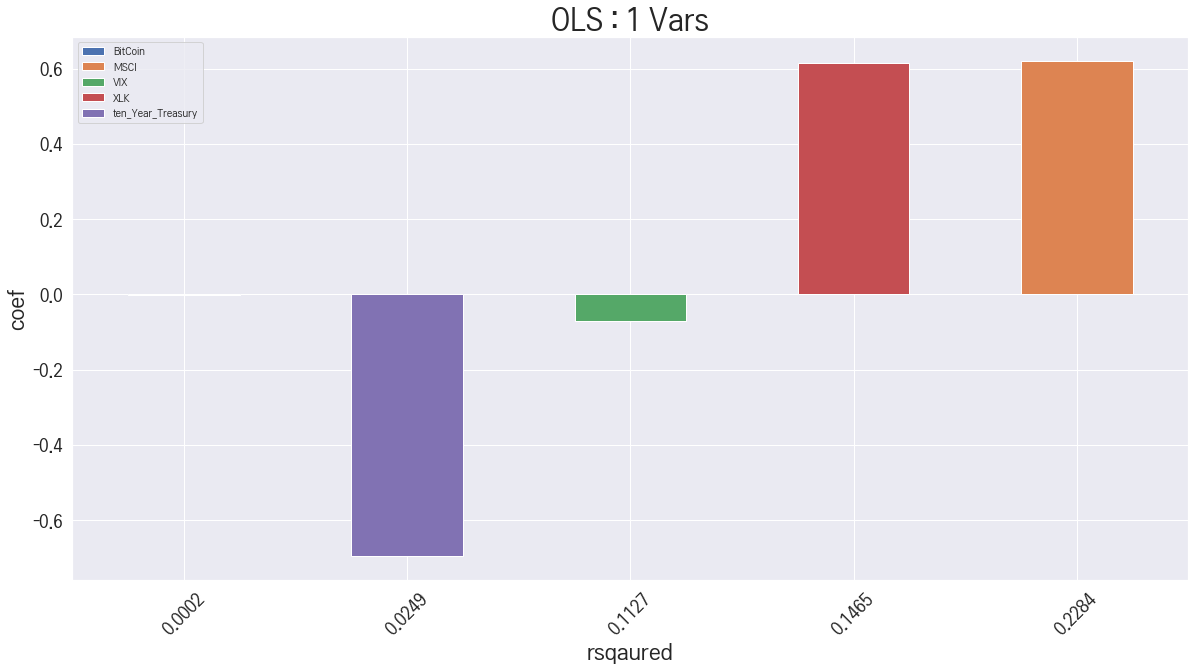

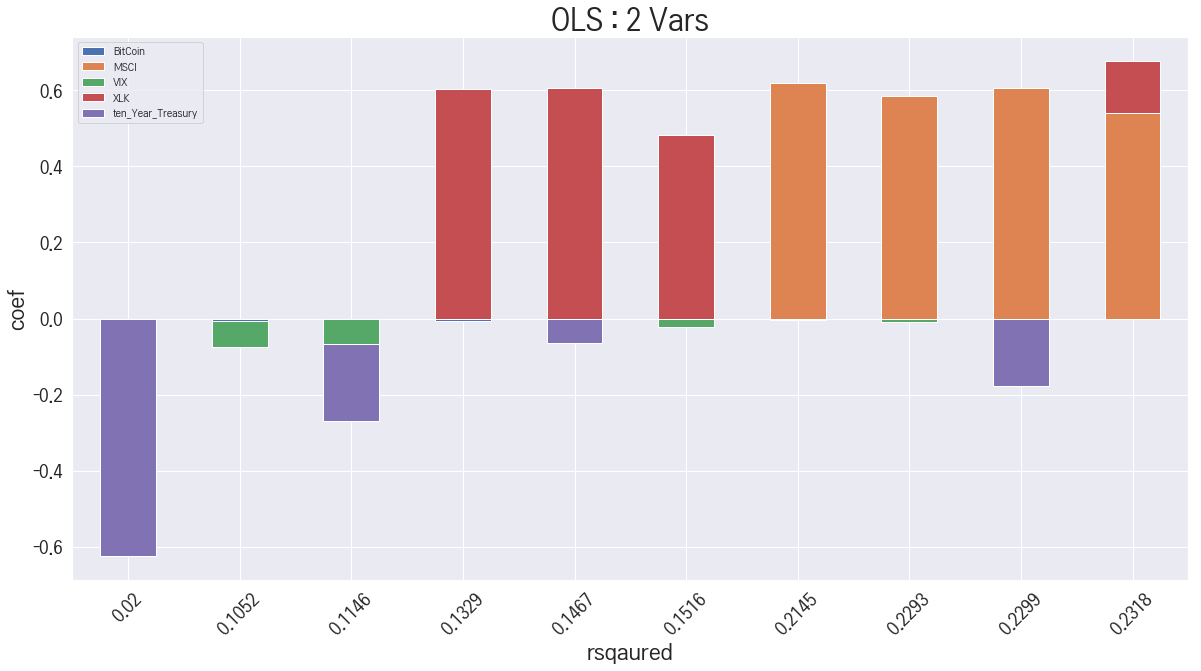

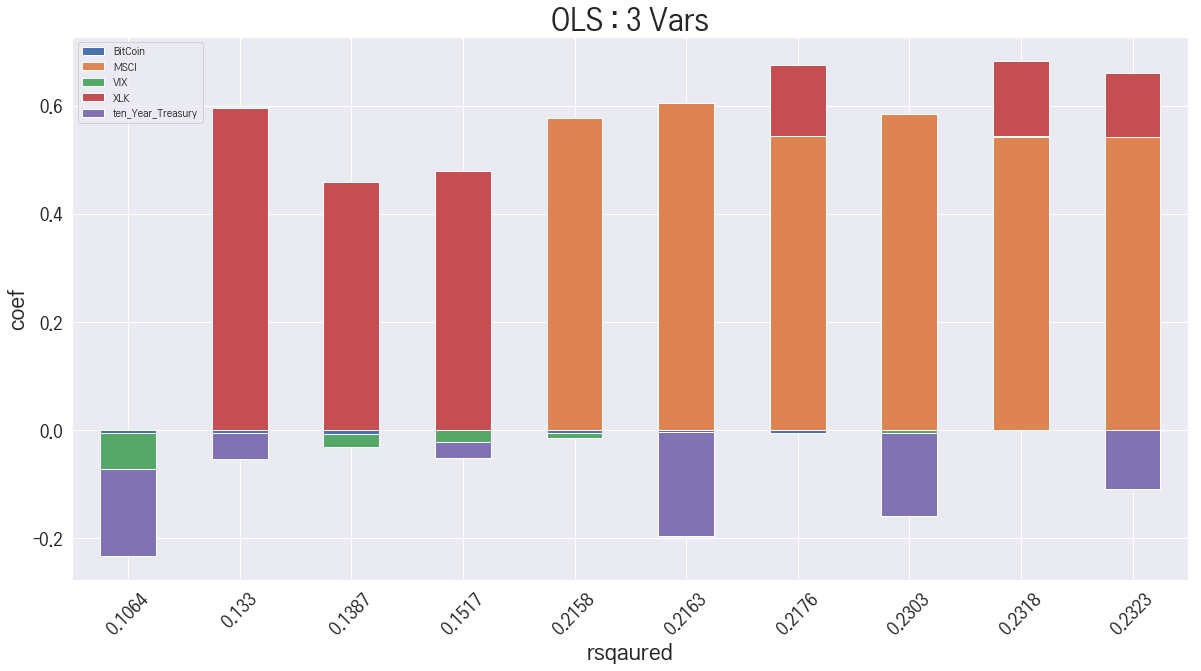

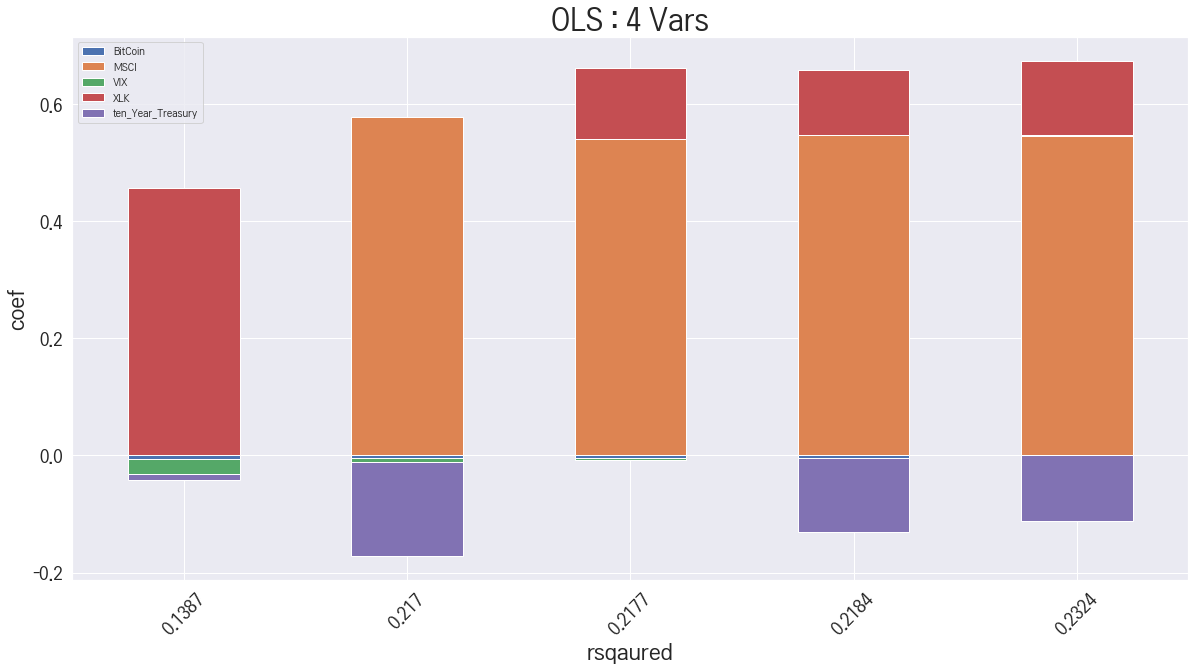

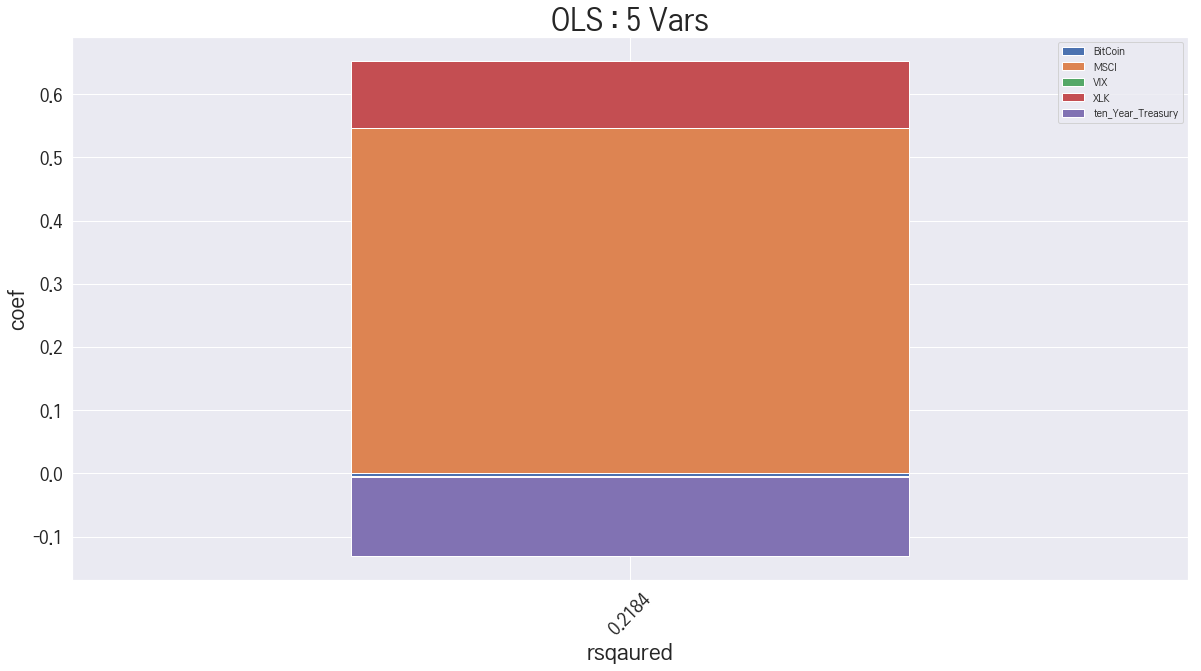

In [4]:
an.ols_comb(comb_num=1,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04', engine='python')
an.ols_comb(comb_num=2,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')
an.ols_comb(comb_num=3,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')
an.ols_comb(comb_num=4,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')
an.ols_comb(comb_num=5,dep='Samsung_Electronics',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')

## [SK 하이닉스](#idx-pr)<a name="sk"></a>

SK 하이닉스 또한 삼성전자와 매우 유사한 결과를 보여줍니다. 

한가지 차이점은 MSCI와의 R스케어과 14% 정도로 훨씬 적어진다는 점입니다. 그 이유는 삼성전자의 MSCI가 큰 영향을 미치는 이유와 동일하다고 생각합니다.

### SK 하이닉스 3개년

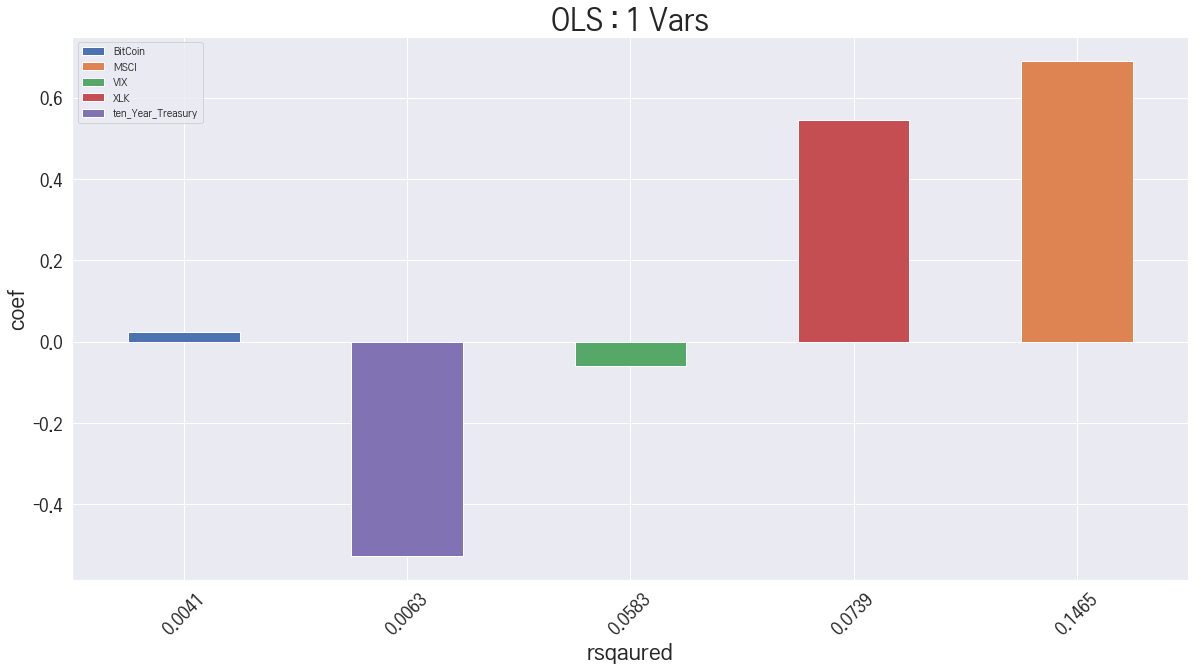

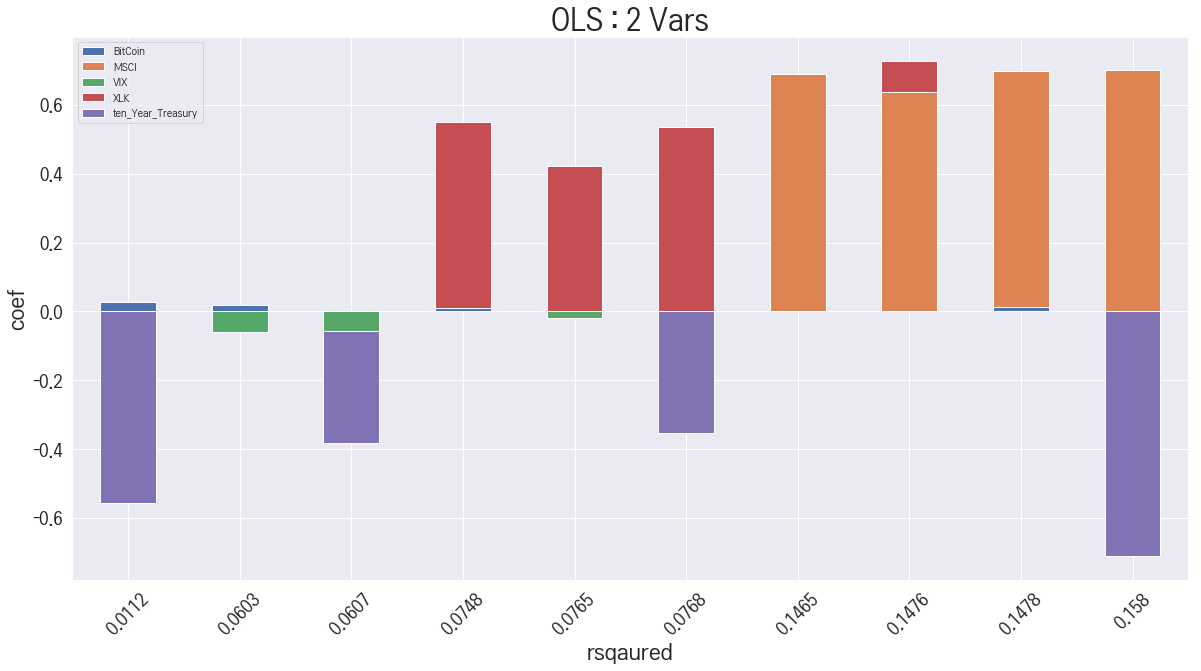

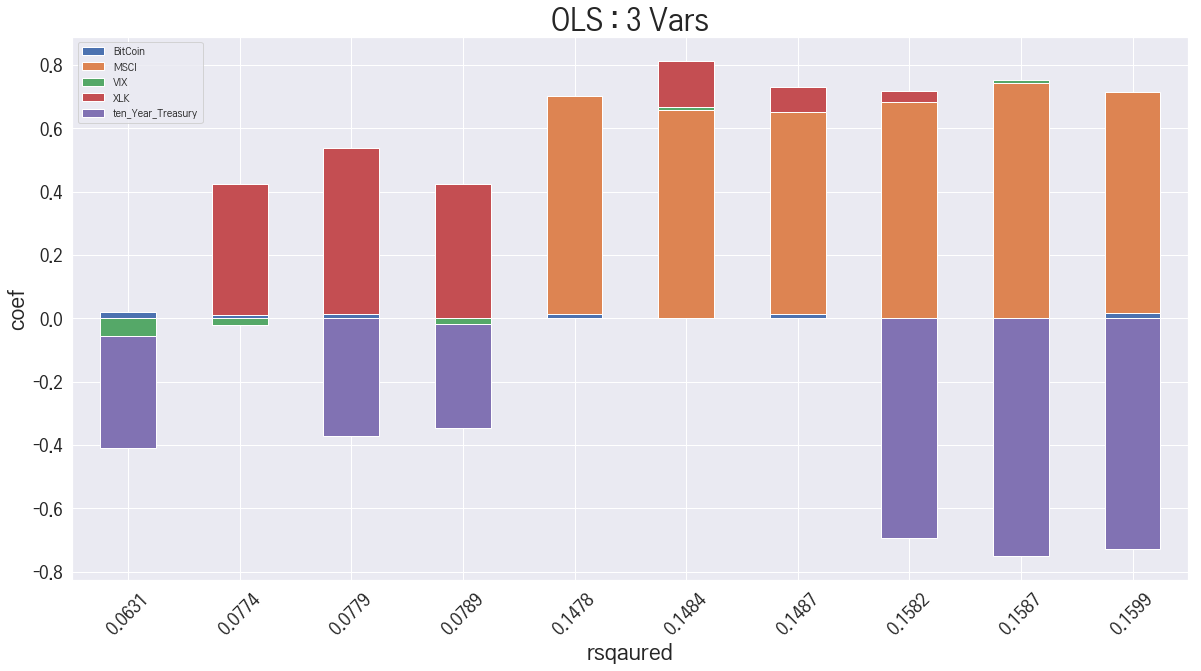

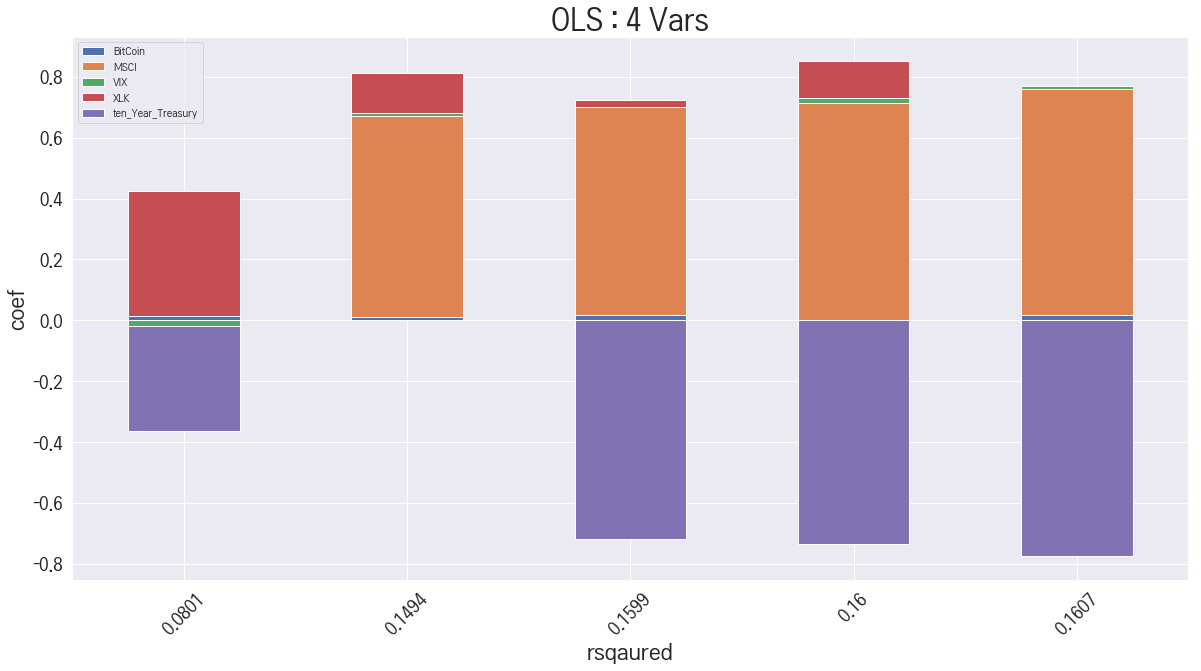

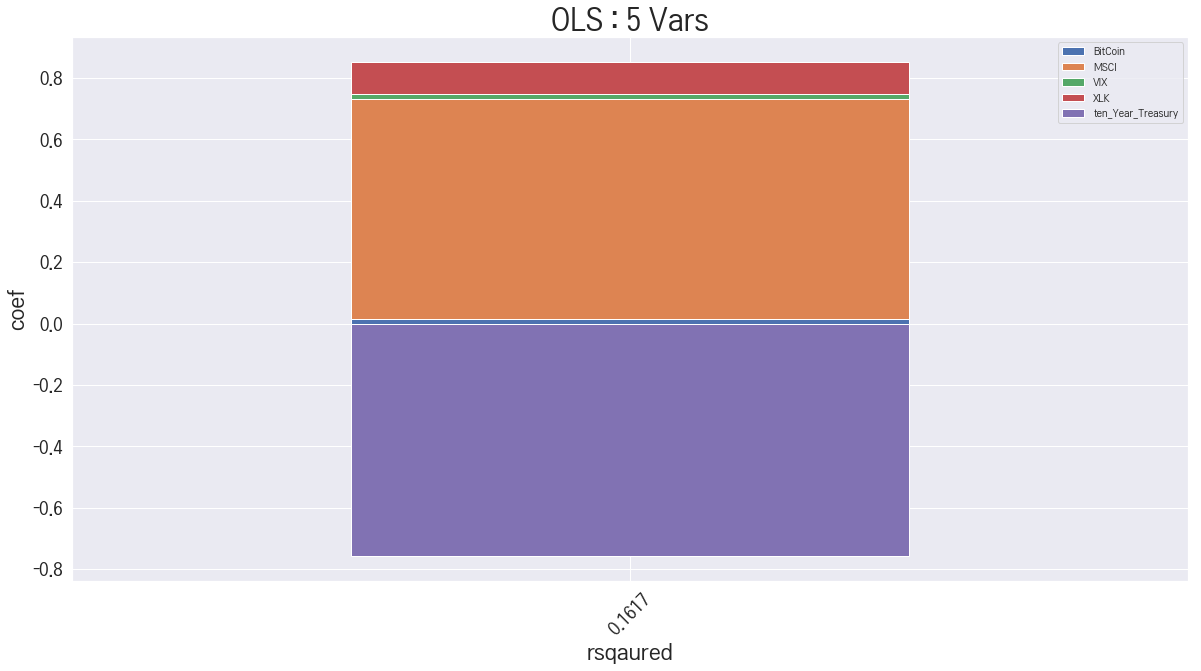

In [5]:
an.ols_comb(comb_num=1,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04', engine='python')
an.ols_comb(comb_num=2,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')
an.ols_comb(comb_num=3,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')
an.ols_comb(comb_num=4,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')
an.ols_comb(comb_num=5,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')

### SK 하이닉스 9개년

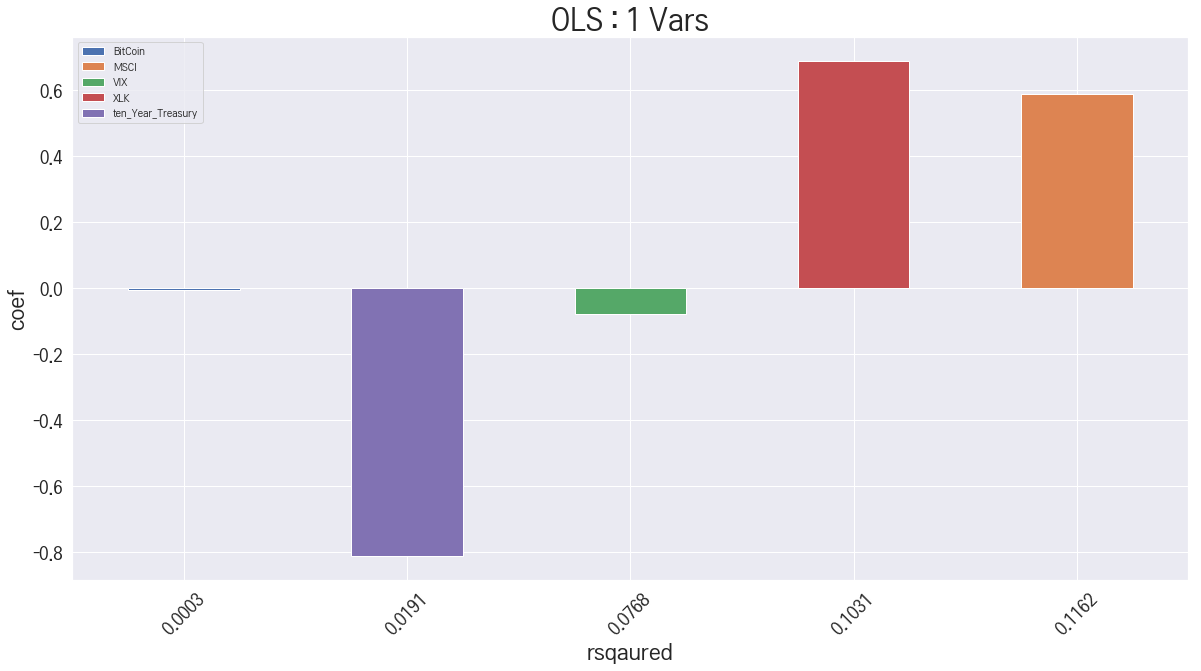

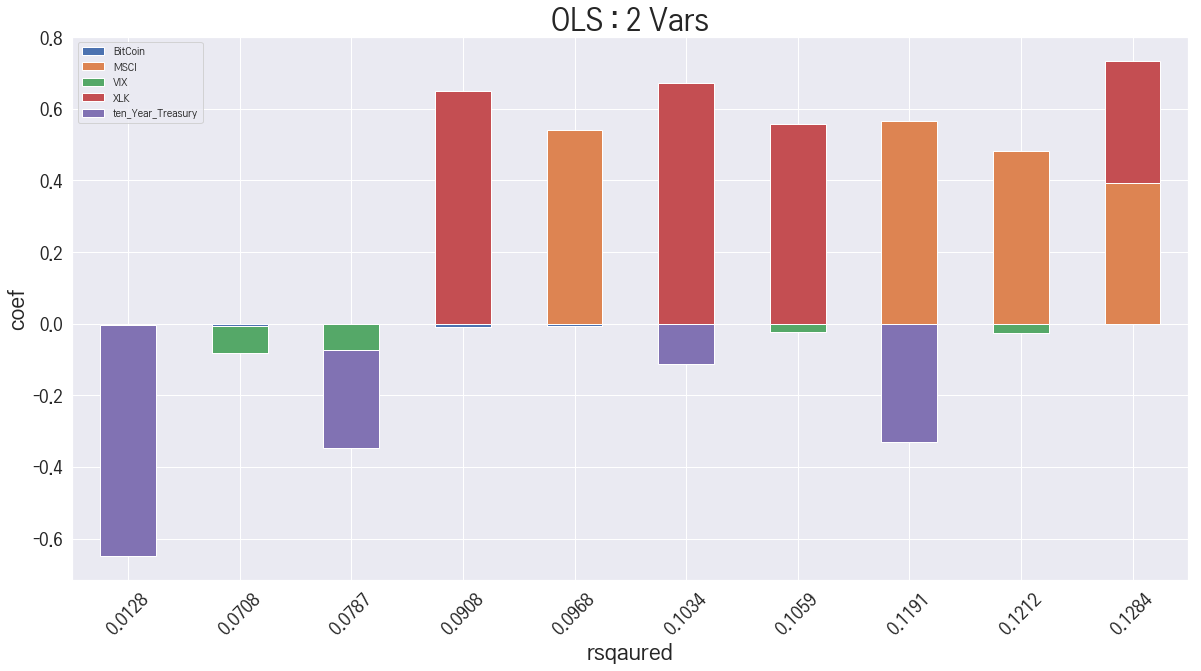

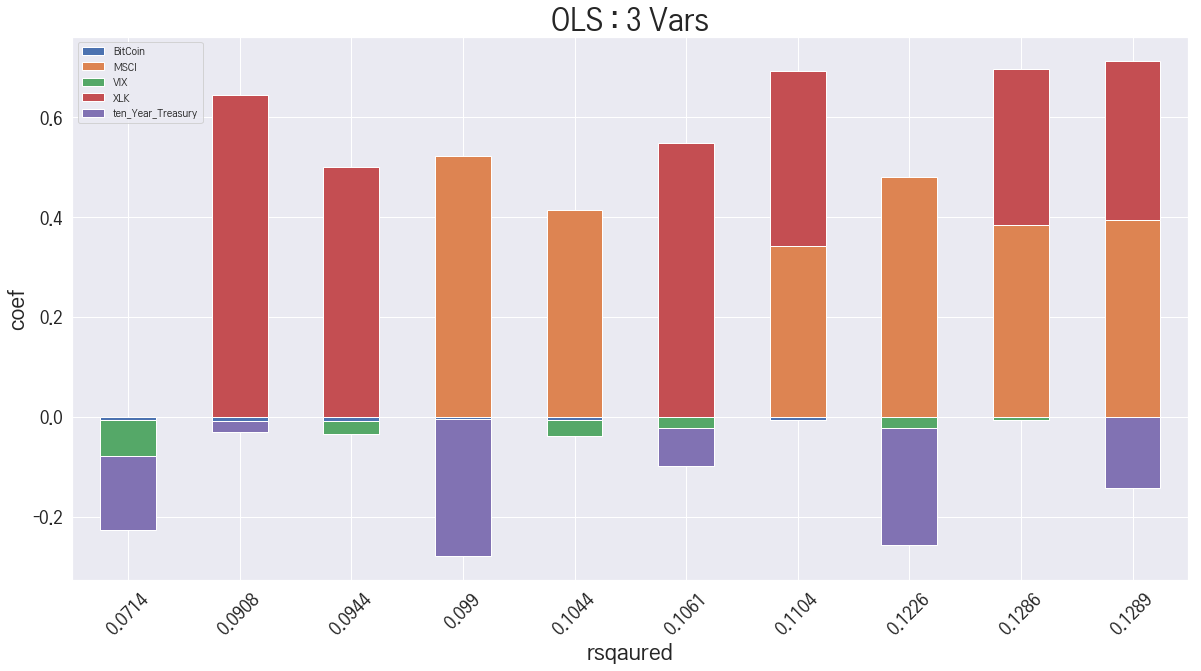

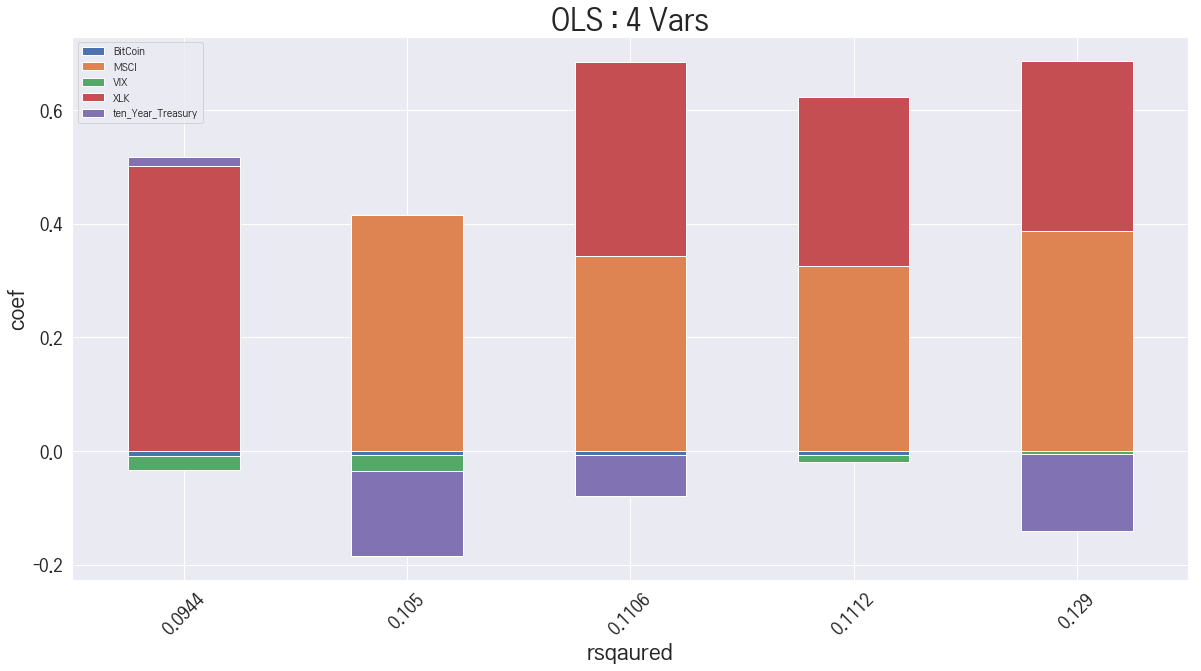

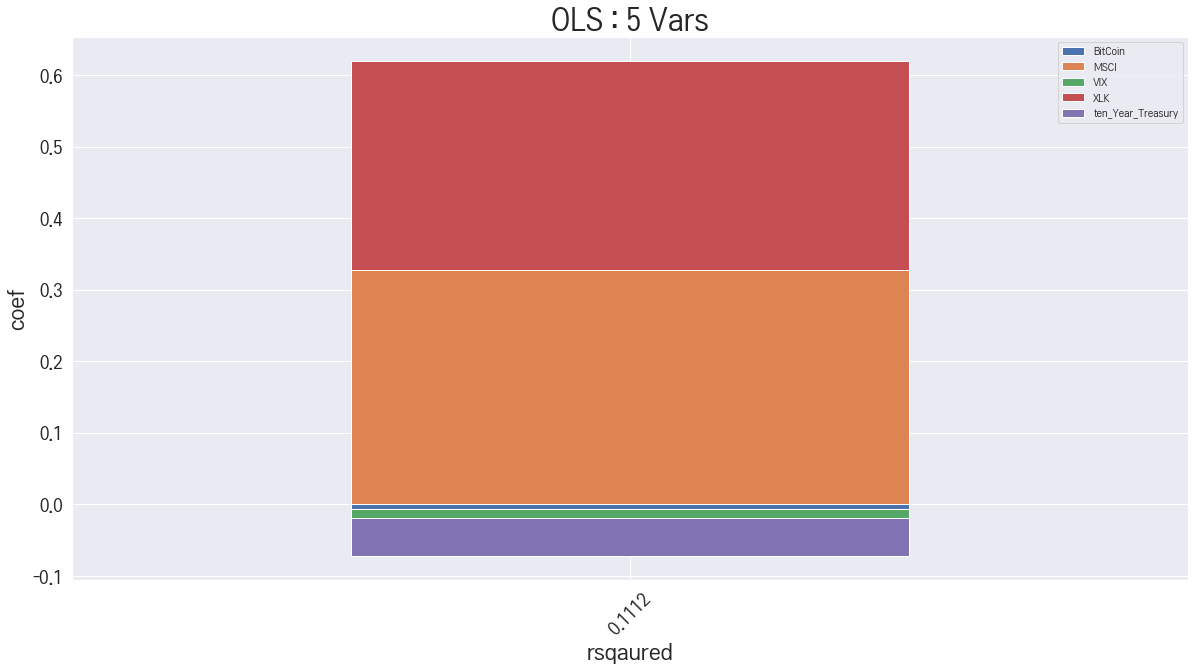

In [6]:
an.ols_comb(comb_num=1,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04', engine='python')
an.ols_comb(comb_num=2,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')
an.ols_comb(comb_num=3,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')
an.ols_comb(comb_num=4,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')
an.ols_comb(comb_num=5,dep='SK_hynix',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2010-01-04',engine='python')

## [네이버](#idx-pr)<a name="naver"></a>

네이버를 보면, 다른 변수들은 앞의 기업들과 동일하지만 미국 금리와는 일관성이 없게 움직이는 모습을 볼 수 있습니다. 

이는 네이버가 글로벌 기업이 아니라 대부분 내수용 기업이라서 잘 맞지 않는 것이라고 생각 하였습니다.

### 네이버 3개년

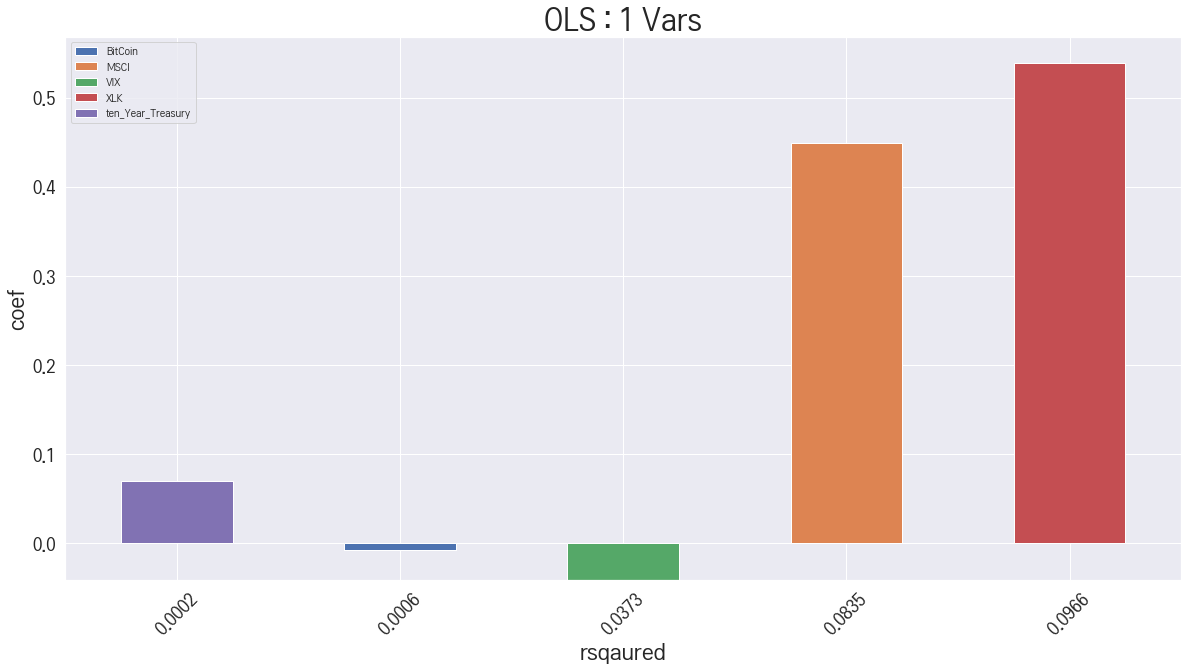

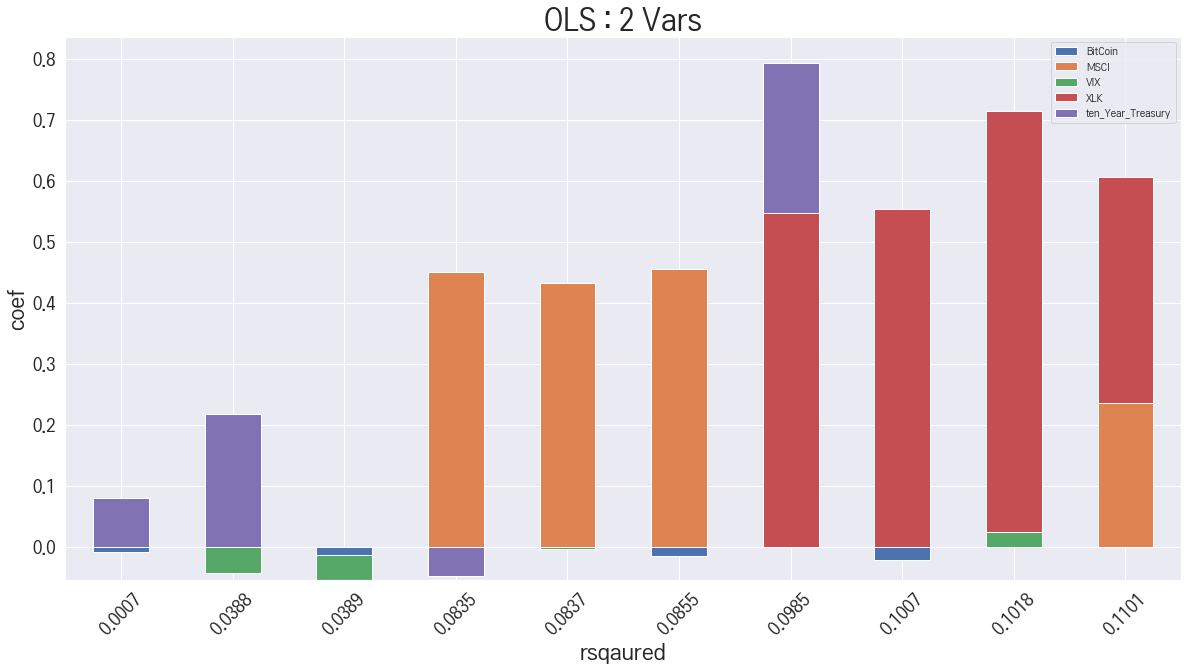

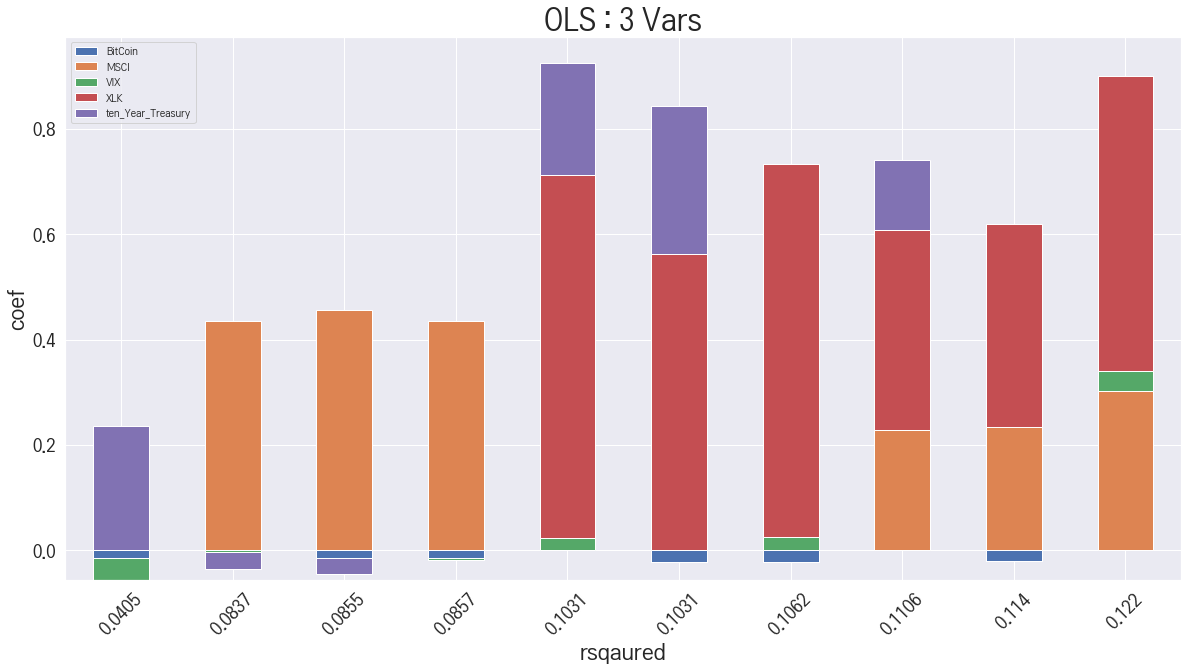

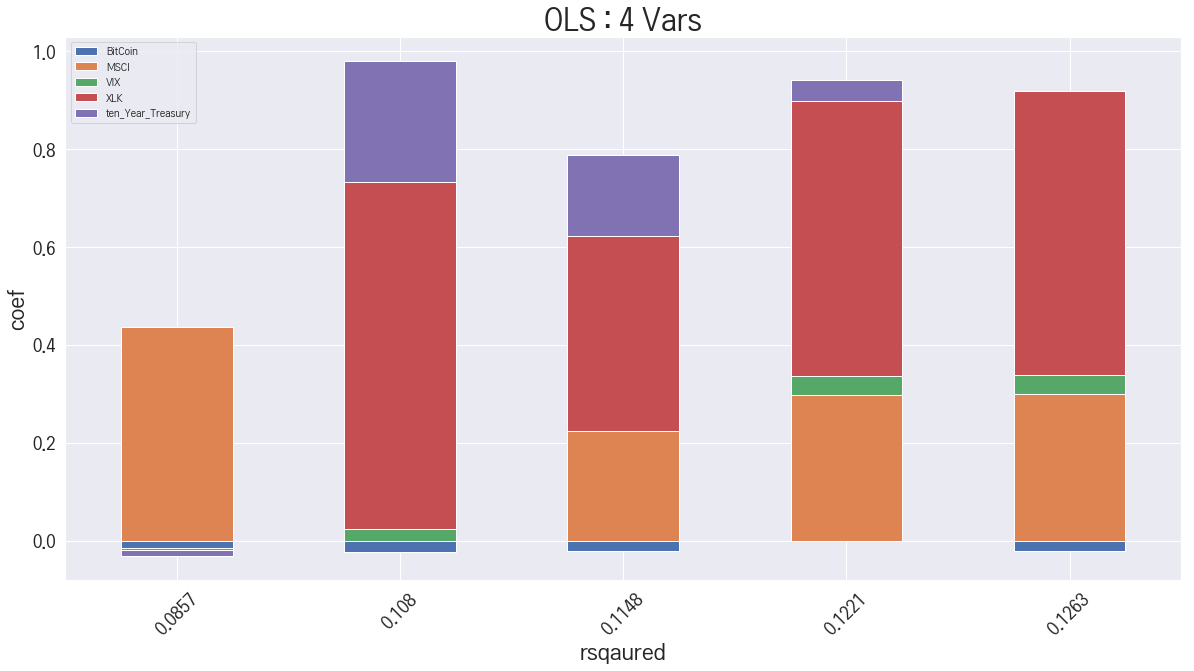

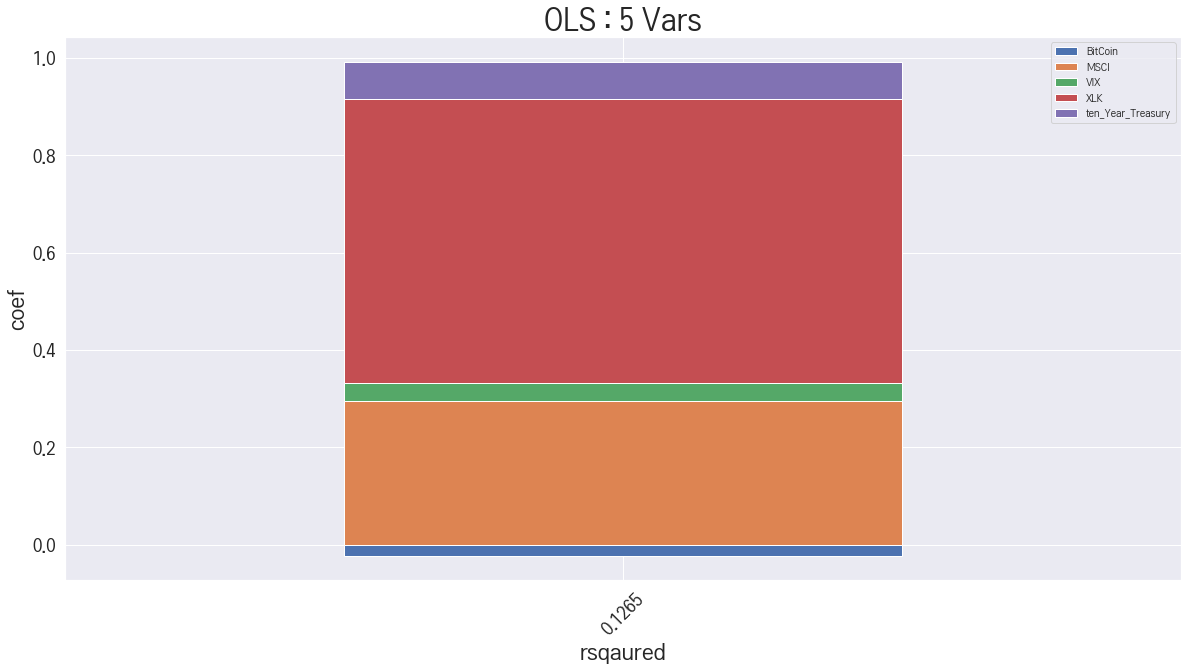

In [7]:
an.ols_comb(comb_num=1,dep='네이버',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04', engine='python')
an.ols_comb(comb_num=2,dep='네이버',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')
an.ols_comb(comb_num=3,dep='네이버',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')
an.ols_comb(comb_num=4,dep='네이버',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')
an.ols_comb(comb_num=5,dep='네이버',inds=stan_US,weekly=True,show_summary=False,show_plot=True,start='2016-01-04',engine='python')

## [결론](#idx-pr)<a name="concl"></a>

저희의 분석 결과, 지수별 상관관계는 기존에 생각하고 있던 부분과 상당히 일치했습니다. 

반도체 산업은 특히 미국과 세계경제 지수에 영향을 많이 받는 것 같습니다. 이는 외국자본의 의존도가 높기 때문이라고 파악했습니다. 

## [추후 계획](#idx-pr)<a name="plan"></a>

코스피와 MSCI 신흥국 지수의 상관관계를 확인하는 과정도 필요할 것으로 예상됩니다. 삼성전자가 코스피 지수에서 차지하는 비중이 매우 큰데 이러한 과정이 MSCI 신흥국 지수에도 분명 영향을 끼칠 것으로 예상되기 때문입니다. 

이러한 설명 변수 간의 상관관계는 결국 공선성으로 인해 회귀 분석 결과에 오류로 이어질 것이라고 생각하여, 이를 해결하기 위해 VAR 모형을 사용해보려고 합니다.

# [데이터 확인](#INDEX)<a name="확인"></a>

2016년부터 2018년 까지의 데이터 plotting.

In [ ]:
an.isValid(stan_US,start='2010-01-04')

In [ ]:
an.isValid(ten_kor)
#an.isValid(ten_US)

# [Symbol List 초기화 & 불러오기](#INDEX)<a name="init"></a>
+ IXT 같은 index 는 잘 안불러진다.
+ 잘 받았는지 검증하는 루틴이 필요함. 

In [ ]:
df = sl.init_symbol_DF()
sl.add_symbol(df,'삼성SDS','018260.KS',init=True)
df = sl.init_symbol_DF()

# [Symbol List 에서 데이터 받기](#INDEX)<a name="down"></a>

TODO::이전에 받은 날짜에 이어서 붙이는거 추가하자.

In [ ]:
sl.download()

# [co-kurtosis](#INDEX)<a name="cokur"></a>
+ how to calculate coskew and cokurtosis
https://stackoverflow.com/questions/41890870/how-to-calculate-coskew-and-cokurtosis

생각을 좀 해봐야겠다.

$$ K(X,X,Y,Y)= {E[(X - E[X])^2(Y - E[Y]^2)] \over \sigma_X^2\sigma_Y^2}$$

변화율로 가야하나, 정규화를 해야하나, 그냥 해도 되나

```python
def cokur(
    target1,
    target2,
    start='2016-01-04',
    end='2018-12-28',
    engine='c',
    value = 'Close'
    ):  
    ```

In [ ]:
df_cokur = pd.DataFrame(columns=['Samsung_Electronics'])
for stans in stan_US:
    tmp = an.cokur('Samsung_Electronics',stans)
    df_cokur.loc[stans] = [tmp['Close']]
display(df_cokur)
df_cokur.plot(kind='bar',rot=45,title='Co-Kurtosis')


# [Joint plot](#INDEX)<a name="joint"></a>
https://seaborn.pydata.org/generated/seaborn.jointplot.html

In [ ]:
for idx in stan_US:
    an.joint('Samsung_Electronics',idx)

In [ ]:
for idx in range(0,len(ten_US)):
    an.joint(ten_US[idx],index_kor)

# [Correlation](#INDEX)<a name="corr"></a>

```python
def corr(
    target1,
    targets,
    start='2016-01-04',
    end='2018-12-28',
    engine='c',
    value = 'Close',
    weekly=True
    ):   
    ```

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['LG PC'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['LG PC'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['LG PC'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


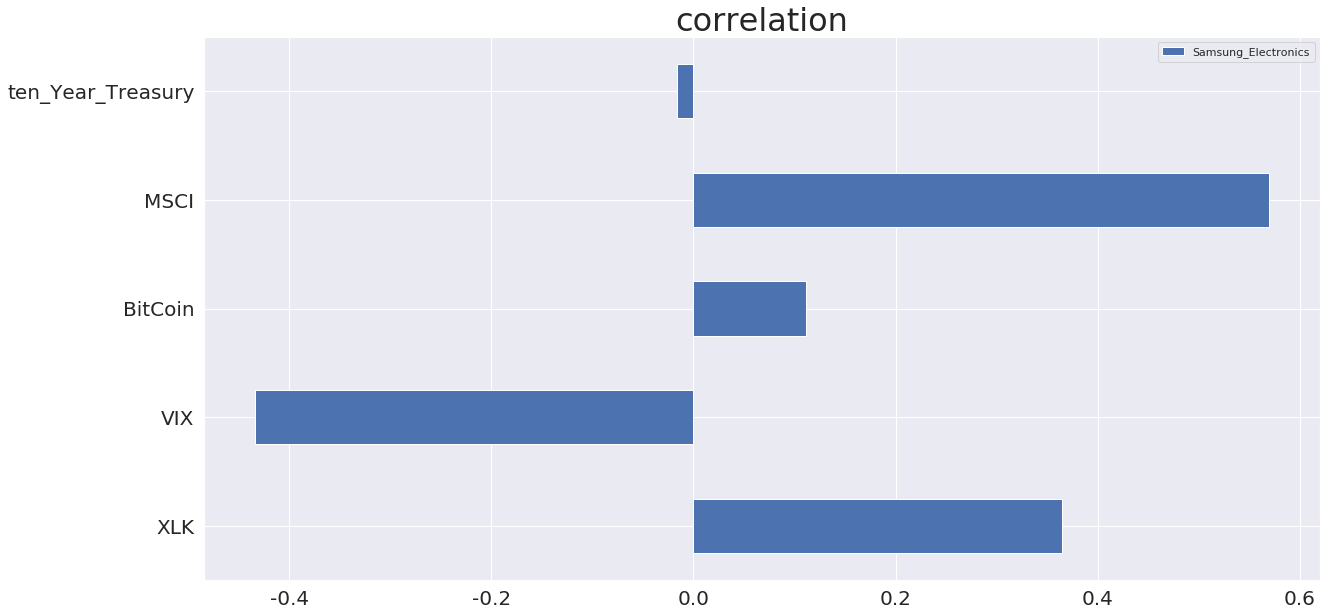

In [2]:
a= an.corr('Samsung_Electronics',stan_US,weekly=True)
b = a.plot(kind='barh',figsize=(20,10), title='correlation',fontsize=20)
b.title.set_size(32)